In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

mat_file_path = '/content/drive/MyDrive/combustion_img_13.mat'

In [3]:
# Open the .mat file
with h5py.File(mat_file_path, 'r') as file:
    train_images = torch.tensor(file['train_set_x'][:], dtype=torch.float)
    train_labels = torch.tensor(file['train_set_y'][:], dtype=torch.long)
    valid_images = torch.tensor(file['valid_set_x'][:], dtype=torch.float)
    valid_labels = torch.tensor(file['valid_set_y'][:], dtype=torch.long)
    test_images = torch.tensor(file['test_set_x'][:], dtype=torch.float)
    test_labels = torch.tensor(file['test_set_y'][:], dtype=torch.long)

    # Reshape the images to [num_samples, channels, height, width]
    train_images = train_images.reshape(-1, 1, 250, 100)
    valid_images = valid_images.reshape(-1, 1, 250, 100)
    test_images = test_images.reshape(-1, 1, 250, 100)

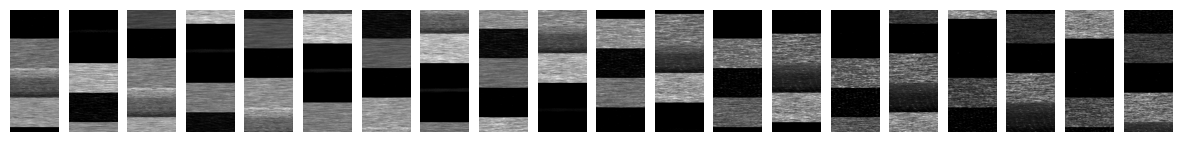

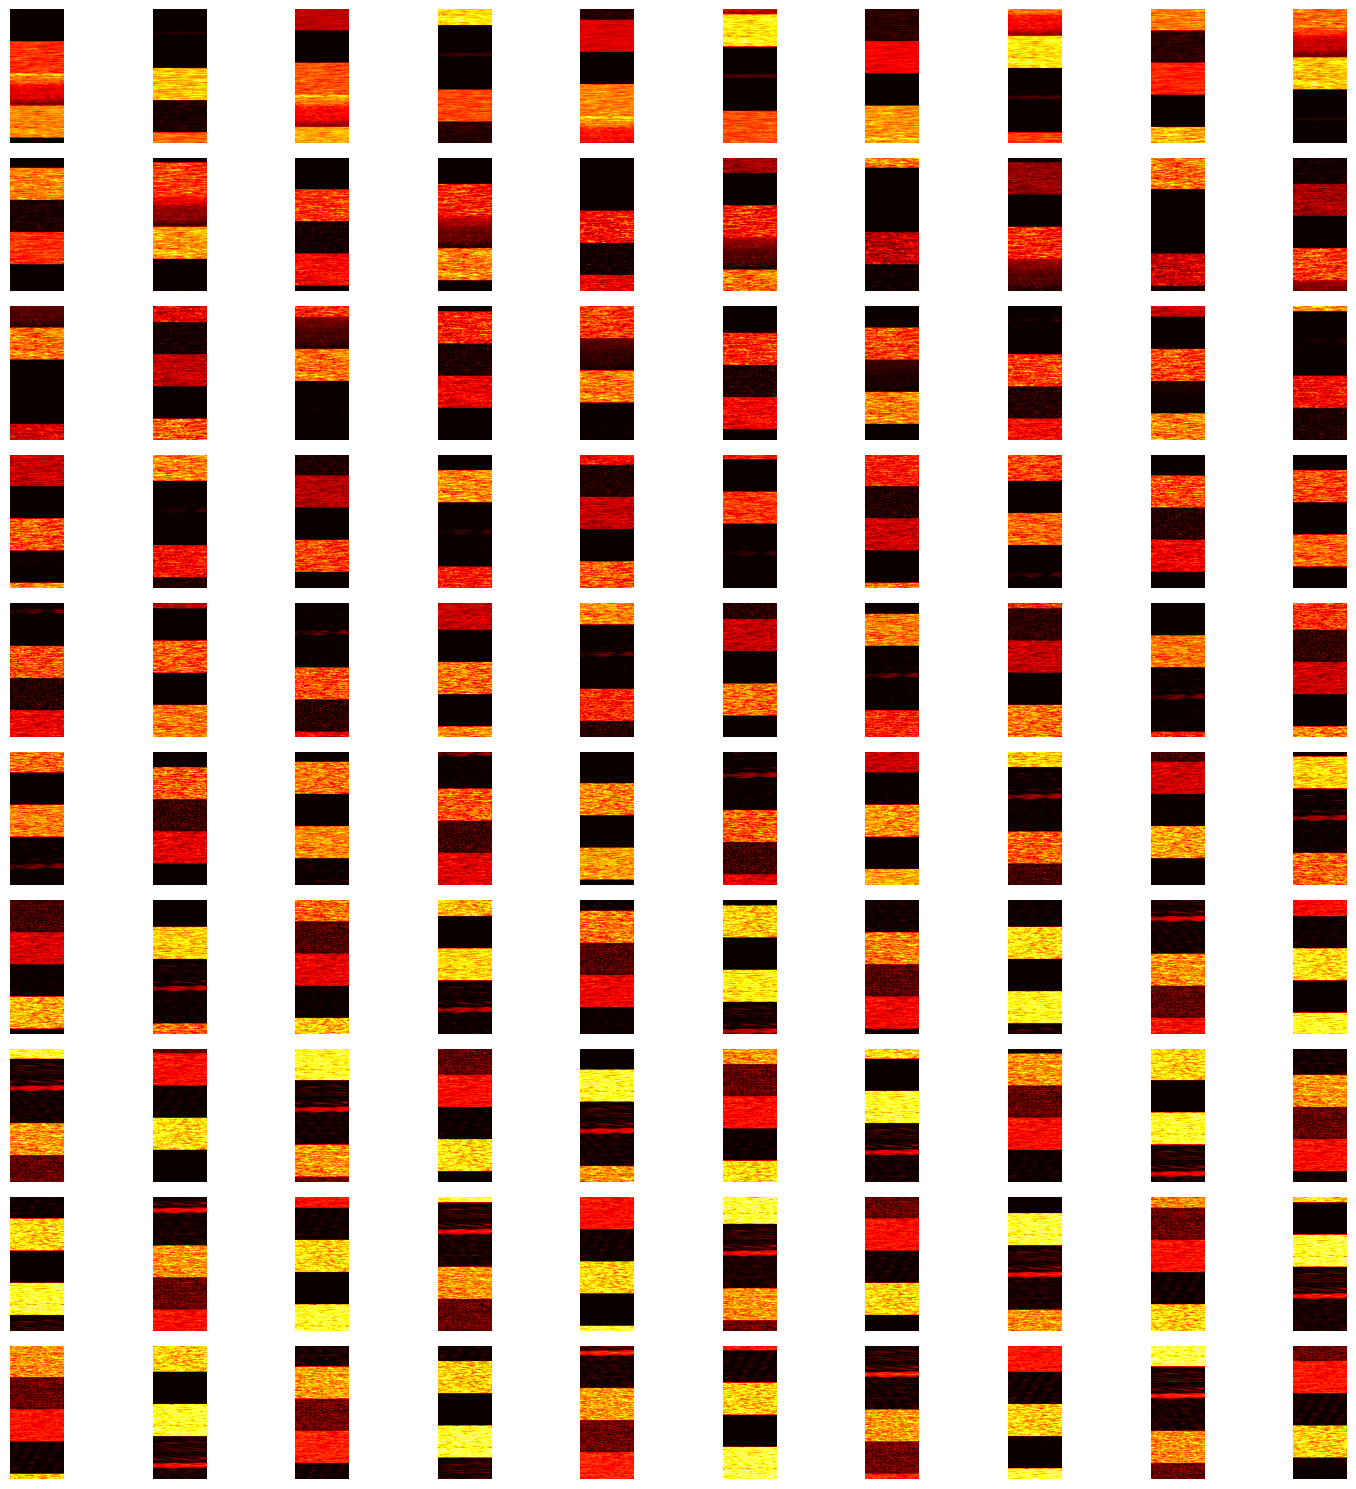

In [11]:
class CombustionDataset(Dataset):
    def __init__(self, file_path, set_type="train"):
        with h5py.File(file_path, 'r') as file:
            if set_type == "train":
                self.data = file['train_set_x'][:]
                self.labels = file['train_set_y'][:]
            elif set_type == "valid":
                self.data = file['valid_set_x'][:]
                self.labels = file['valid_set_y'][:]
            elif set_type == "test":
                self.data = file['test_set_x'][:]
                self.labels = file['test_set_y'][:]

        self.data = torch.tensor(self.data, dtype=torch.float).reshape(-1, 1, 250, 100)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
# Use the dataset with a DataLoader
train_dataset = CombustionDataset(mat_file_path, set_type="train")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
# Training loop for the Autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    outputs = autoencoder(train_images)
    loss = criterion(outputs, train_images)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# After training the Autoencoder, get the latent features
latent_features_train = autoencoder.encoder(train_images).detach()
latent_features_valid = autoencoder.encoder(valid_images).detach()

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0

    for batch_images, _ in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(batch_images.todevice)
        loss = criterion(outputs, batch_images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss}")

RuntimeError: The size of tensor a (104) must match the size of tensor b (100) at non-singleton dimension 3

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self):
        super(SequentialModel, self).__init__()
        # Assuming the latent space size is 64*32*13 from the encoder output
        self.lstm = nn.LSTM(input_size=64*32*13, hidden_size=100, num_layers=2, batch_first=True)
        self.fc = nn.Linear(100, 2)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Use the last output for classification
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 62 * 25, 1000)
        self.fc2 = nn.Linear(1000, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 62 * 25)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Extract latent features for train and validation sets
def extract_latent_features(model, dataset):
    model.eval()
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features = []
    with torch.no_grad():
        for batch_images, _ in loader:
            batch_features = model.encoder(batch_images)
            features.append(batch_features)

    return torch.cat(features, 0)

In [ ]:
# Instantiate and train the SequentialModel
sequential_model = SequentialModel()
optimizer_seq = torch.optim.Adam(sequential_model.parameters(), lr=1e-3)
criterion_seq = nn.CrossEntropyLoss()

NameError: name 'SequentialModel' is not defined

In [ ]:
latent_features_train = latent_features_train.view(latent_features_train.size(0), -1, 64*32*13)
latent_features_valid = latent_features_valid.view